In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("../roll_data/*-triples.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# select season (zero indexed)
season = 14
df = df[df["season"] == season]

# Triples Analysis

Works *roughly* with `defense_average_chasiness` as a factor but has many problems. Most likely uses a specific fielder, whose attributes we need to be able to pull in. Fun!

Seems to be different between S14 and S15: several ballpark factors change sign in S15, and shrink in importance. as an example, the current fit for S14 gives:
```
[0.01818613]
(0.19843638427639265, 'gf_vibes')
(-0.043779832725212346, 'op_vibes')
(-0.04539174061951756, 'defense_avg_chasiness')
(0.009948209917303216, 'ballpark_ominousness')
(-0.016469063710629027, 'ballpark_viscosity')
(0.013901501986086438, 'ballpark_forwardness')
(0.0029566536469647843, 'ballpark_elongation')
(0.05040983250181947, 'ballpark_grandiosity')
```
while for S15 it gives:
```
[0.02096347]
(0.1949570430812243, 'gf_vibes')
(-0.04440774308462537, 'op_vibes')
(-0.0444106526951429, 'defense_avg_chasiness')
(-0.004740179730049955, 'ballpark_ominousness')
(0.0029113436580619745, 'ballpark_viscosity')
(0.03476008958255702, 'ballpark_forwardness')
(-0.0008334860432481537, 'ballpark_elongation')
(0.02678564950791311, 'ballpark_grandiosity')
```

Viscosity, ominousness, and elongation all changed sign here, going from "the expected direction" to the opposite direction. This probably means they stop being included in S15. Leaving them out of the fit gives:
```
[0.0198066]
(0.19500371831614302, 'gf_vibes')
(-0.04439155329748978, 'op_vibes')
(-0.04442102341834728, 'defense_avg_chasiness')
(0.032556276647441776, 'ballpark_forwardness')
(0.028276137687796202, 'ballpark_grandiosity')
```

In [2]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]  # * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]  # * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]  # * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2 / freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes


def get_pitcher_mul(row):
    bm = str(row["batter_mods"])
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass  # traveling just doesn't do anything on pitchers?
    #         if not row["top_of_inning"]:
    #             mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        #         mul += min(0.05, 0.05 * (row["day"] / 99))
        pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    #         pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        #         pass
        mul += 1.0
    if "SMOOTH" in bm and row["weather"] == 10:
        # todo: handle, in peanuts weather
        pass
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
    #         pass
    return mul

In [3]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

df["gf_times_batter_vibes"] = df["batter_ground_friction"] * df["batter_vibes"]
df["op_times_pitcher_vibes"] = df["pitcher_overpowerment"] * df["pitcher_vibes"]

df["gf_scaled"] = df["batter_ground_friction"] * df["batter_mul"]
df["op_scaled"] = df["pitcher_overpowerment"] * df["pitcher_mul"]


df["gf_vibes"] = df["gf_scaled"] * (1 + 0.2 * df["batter_vibes"])
df["op_vibes"] = df["op_scaled"] * (1 + 0.2 * df["pitcher_vibes"])

dfc = df.copy()

dfc = dfc[(dfc["pitcher_mul"] == 1) & (dfc["batter_mul"] == 1)]
# dfc = dfc[(dfc['pitcher_vibes'].abs() < 0.2) & (dfc['batter_vibes'].abs() < 0.2)]

In [4]:
# X = df[['roll', 'batter_ground_friction', 'pitcher_overpowerment', 'defense_avg_chasiness',
#         'ballpark_ominousness', 'ballpark_viscosity', 'ballpark_forwardness',
#         'batter_vibes', 'pitcher_vibes', 'gf_times_batter_vibes', 'op_times_pitcher_vibes']].copy()

# season 14 set? (with the avg chasiness which i suspect is wrong)
X = dfc[
    [
        "roll",
        "gf_vibes",
        "op_vibes",
        "defense_avg_chasiness",
        "ballpark_ominousness",
        "ballpark_viscosity",
        "ballpark_forwardness",
        "ballpark_elongation",
        "ballpark_grandiosity",
    ]
].copy()

# season 15 set? (with the avg chasiness which i suspect is wrong)
X = dfc[
    [
        "roll",
        "gf_vibes",
        "op_vibes",
        "defense_avg_chasiness",
        "ballpark_forwardness",
        "ballpark_grandiosity",
    ]
].copy()

y = dfc["passed"]

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X2 = sc.fit_transform(X)
trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=10000, tol=1e-6).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[4410   32]
 [  37  588]]
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      4442
        True       0.95      0.94      0.94       625

    accuracy                           0.99      5067
   macro avg       0.97      0.97      0.97      5067
weighted avg       0.99      0.99      0.99      5067

0.9863824748371818


In [6]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]

print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.0198066]


[(1.0, 'roll'),
 (-0.19500371831614302, 'gf_vibes'),
 (0.04442102341834728, 'defense_avg_chasiness'),
 (0.04439155329748978, 'op_vibes'),
 (-0.032556276647441776, 'ballpark_forwardness'),
 (-0.028276137687796202, 'ballpark_grandiosity')]

In [7]:
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

[0.0198066]
(0.19500371831614302, 'gf_vibes')
(-0.04439155329748978, 'op_vibes')
(-0.04442102341834728, 'defense_avg_chasiness')
(0.032556276647441776, 'ballpark_forwardness')
(0.028276137687796202, 'ballpark_grandiosity')


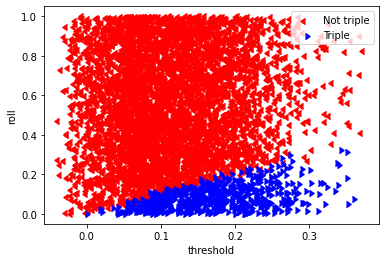

In [8]:
# df['flinch'] = (df["batter_mods"].astype(str).str.contains("FLINCH") & (df["strike_count"] == 0)).astype(int)
# df["threshold"] = 0.082508 + df["batter_ground_friction"] * 0.2 - df["pitcher_overpowerment"] * 0.045 - df["ballpark_ominousness"] * 0.4 - df["ballpark_viscosity"] * 0.025 - df["ballpark_forwardness"] * 0.025

x_val = "threshold"
# x_val = "svc"
fig, ax = plt.subplots(1)
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]]["roll"],
    color="red",
    label="Not triple",
    marker=CARETLEFTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]]["roll"],
    color="blue",
    label="Triple",
    marker=CARETRIGHTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_xlim(0.48, 0.52)

# min_x, max_x = ax.get_xlim()
# xx = np.linspace(min_x - 0.1, max_x + 0.1)
# yy = xx * 0.35 + 0.35
# ax.plot(xx, yy)

ax.legend()

# fig.savefig("../figures/"+x_val+".png", facecolor='white')
# endpoints = np.array(ax.get_xlim())
# ax.plot(endpoints, 0.35 + 0.35 * endpoints)

69


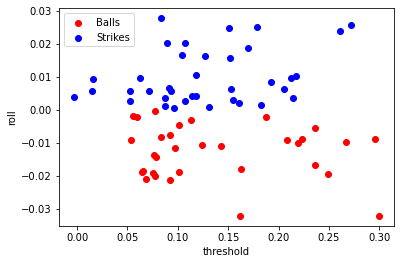

In [9]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]

outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
print(outliers.shape[0])

fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 10)
x_val = "threshold"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="Balls",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Strikes",
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.legend()

In [10]:
col_list = [
    "event_type",
    "roll",
    "threshold",
    "offset",
    "gf_vibes",
    "op_vibes",
    "batter_vibes",
    "pitcher_vibes",
    "batter_mul",
    "pitcher_mul",
    "ballpark_viscosity",
    "ballpark_ominousness",
    "ballpark_forwardness",
    "defense_avg_chasiness",
    "batter_name",
    "pitcher_name",
    "game_id",
    "play_count",
    "batter_mods",
    "pitcher_mods",
    "batting_team_mods",
    "pitching_team_mods",
    "day",
    "game_id",
    "play_count",
]
# outliers[(outliers['threshold'] > 0.1) &
#          (outliers["batter_mods"].astype(str).str.contains("ON_FIRE"))].sort_values('offset', ascending=True).loc[:, col_list][0:10]
outliers.sort_values("offset", ascending=False).loc[:, col_list]

,event_type,roll,threshold,offset,gf_vibes,op_vibes,batter_vibes,pitcher_vibes,batter_mul,pitcher_mul,...,pitcher_name,game_id,play_count,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
10062,Hit3,0.110731,0.082968,0.027763,0.486811,0.837407,0.267787,-0.184211,1.0,1.0,...,Chambers Simmons,a4f1b9c9-241e-4ff0-a27f-1ccb4a497e97,208,SIPHON,NaN,BASE_INSTINCTS,GROWTH,84,a4f1b9c9-241e-4ff0-a27f-1ccb4a497e97,208
9404,Hit3,0.297254,0.271680,0.025574,1.386619,0.551053,-0.128620,-0.023166,1.0,1.0,...,Bontgomery Mullock,ec008c57-c374-45b9-a0ca-c4677a86e076,57,SIPHON;FIRE_EATER;FLINCH;DOUBLE_PAYOUTS;EGO2,FRIEND_OF_CROWS;WILD,CARCINIZATION;UNHOLEY,LOVE,80,ec008c57-c374-45b9-a0ca-c4677a86e076,57
9810,Hit3,0.203986,0.178761,0.025225,1.063891,1.032050,0.378893,-0.073928,1.0,1.0,...,Snyder Briggs,6d12517b-04e7-4344-a214-4bd642f234d5,270,NaN,ALTERNATE;WILD,AFFINITY_FOR_CROWS,TRAVELING,82,6d12517b-04e7-4344-a214-4bd642f234d5,270
9589,Hit3,0.175418,0.150593,0.024824,0.759421,0.568660,0.289188,-0.339857,1.0,1.0,...,Stevenson Heat,38c053a8-fd06-4df3-ac74-55dbcf84ea38,101,ALTERNATE,ALTERNATE;FRIEND_OF_CROWS,CARCINIZATION;UNHOLEY,SINKING_SHIP,81,38c053a8-fd06-4df3-ac74-55dbcf84ea38,101
7866,Hit3,0.284673,0.260650,0.024023,1.330912,0.354595,0.639176,0.007704,1.0,1.0,...,Adalberto Tosser,12b78c15-bea6-4826-b031-694a58d660b1,82,SPICY,WILD;CREDIT_TO_THE_TEAM,NaN,CARCINIZATION;UNHOLEY,46,12b78c15-bea6-4826-b031-694a58d660b1,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8080,Hit1,0.057437,0.077564,-0.020127,0.538972,1.073320,-0.708034,0.718935,1.0,1.0,...,Caleb Alvarado,92ef4c0e-0ede-46d2-9f75-e3789e1d99a7,171,NaN,FRIEND_OF_CROWS,SUN_KISSED;SUN2_PAYOUTS,NaN,47,92ef4c0e-0ede-46d2-9f75-e3789e1d99a7,171
7060,Hit1,0.047330,0.068214,-0.020884,0.401784,0.790434,-0.690521,0.798166,1.0,1.0,...,King Roland,4c1e39b7-62af-4838-871e-af868e4e1a48,245,NaN,NaN,LIFE_OF_PARTY;ELECTRIC,LOVE,40,4c1e39b7-62af-4838-871e-af868e4e1a48,245
11466,Hit1,0.070557,0.091805,-0.021248,0.457942,0.461857,-0.044605,-0.819986,1.0,1.0,...,Ankle Halifax,aedfedc2-9b55-4f59-b11a-01adb390352e,24,SIPHON,NaN,BASE_INSTINCTS,UNDERSEA;PARTY_TIME,94,aedfedc2-9b55-4f59-b11a-01adb390352e,24
9936,Hit1,0.129101,0.161259,-0.032158,0.940038,0.882252,0.522667,0.173489,1.0,1.0,...,Bright Zimmerman,42a824ba-bd7b-4b63-aeb5-a60173df136e,241,NaN,WANDERER,AFFINITY_FOR_CROWS,TRAVELING,83,42a824ba-bd7b-4b63-aeb5-a60173df136e,241


In [11]:
dfc[dfc["event_type"] == "Hit3"]["roll"].max()

0.3257678313075585